In [1]:
# Enable python to import modules from parent directory
import sys
sys.path.append("..")

from src.config import *


import pandas as pd

data_path = os.path.join(DATA_CLEAN_PATH, "ml-curated-data.csv")
data = pd.read_csv(data_path, encoding='latin1')

from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

target_col = 'wage_increase'
features = [c for c in data.columns if c != target_col]

df=data.dropna(subset=[target_col])

X = df[['lag_11','lag_7','lag_6','lag_3','lag_2','lag_1','state','gender','age']]
Y = df['wage_increase']
print(X)
print(Y)

         lag_11     lag_7     lag_6     lag_3     lag_2     lag_1     state  \
0      0.024181 -0.053836 -0.023294 -0.087671  0.059876  0.032627  0.015672   
1      0.001615 -0.023294 -0.063004  0.059876  0.032627  0.075232  0.015672   
2      0.002881 -0.063004  0.131306  0.032627  0.075232 -0.021322  0.015672   
3      0.093041  0.131306 -0.087671  0.075232 -0.021322 -0.023162  0.015672   
4     -0.053836 -0.087671  0.059876 -0.021322 -0.023162 -0.028393  0.015672   
...         ...       ...       ...       ...       ...       ...       ...   
11259  0.275406 -0.005880 -0.122001  0.264542 -0.021666 -0.160835  0.022000   
11260 -0.089079 -0.122001  0.126975 -0.021666 -0.160835  0.041502  0.022000   
11261  0.094602  0.126975 -0.166937 -0.160835  0.041502  0.086506  0.022000   
11262  0.099610 -0.166937  0.264542  0.041502  0.086506 -0.102456  0.022000   
11263 -0.005880  0.264542 -0.021666  0.086506 -0.102456  0.118147  0.022000   

         gender       age  
0      0.019090  0.0168

In [2]:
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=.3,random_state = 1)

In [3]:
len (X_train), len (X_test), len (y_train), len (y_test)
scaler=StandardScaler()
scaler.fit(X_train)

X_train=scaler.transform(X_train)
X_test = scaler.transform(X_test)
len(X_train), len(X_test)

(7884, 3380)

In [4]:
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [100,200,500]}
xgb1 = XGBRegressor()
xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(X_train,y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

xbgGS=pd.DataFrame(xgb_grid.cv_results_)
len(xbgGS)

objs = [xbgGS, pd.DataFrame(xbgGS['params'].tolist()).iloc[:, :2]]
results=pd.concat(objs, axis=1).drop('params', axis=1)
results.to_csv('XGBRegressionResults.csv')

Fitting 2 folds for each of 27 candidates, totalling 54 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   55.7s
[Parallel(n_jobs=5)]: Done  54 out of  54 | elapsed:  1.4min finished
C:\Users\Android\.conda\envs\e7satai\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


0.2536789743963589
{'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 200, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}


In [5]:
print(results)

    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        2.567647      0.330519         0.021501        0.002500   
1        4.505758      1.396580         0.035502        0.000500   
2       10.077076      1.319575         0.087005        0.006000   
3        2.500643      0.531530         0.021501        0.000500   
4        5.418810      1.878607         0.076004        0.034002   
5       12.827734      2.557146         0.127007        0.019001   
6        1.256572      0.285516         0.028502        0.000500   
7        4.911281      1.726099         0.069004        0.007000   
8       16.758459      0.241514         0.127007        0.009000   
9        1.830105      0.175010         0.021501        0.001500   
10       3.534202      0.528030         0.039002        0.004000   
11       9.421539      3.871222         0.099506        0.014501   
12       3.295189      2.487142         0.026001        0.004000   
13       3.894223      0.551031         0.041502

In [6]:
#params={'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}
model=XGBRegressor(**xgb_grid.best_params_)
X_train=X_test
y_train=y_test
model.fit(X_train,y_train)
#print(model.score(X_test,y_test))

predictions=model.predict(X_train)

#from sklearn.metrics import mean_squared_error
#from math import sqrt
#print("R^2: ", r2_score(y_test,predictions))
#rms = sqrt(mean_squared_error(y_train, predictions))
#print("RMS: ", rms)
#mse = mean_squared_error(y_train, predictions)
#print("MSE: ", mse)
#len(y_test)

In [7]:
import numpy as np
estimatesGBR = predictions
errorGBR = np.asmatrix(y_train.values - estimatesGBR)
sme = (errorGBR.T * errorGBR / len(errorGBR)).tolist()[0][0]
sme,np.sqrt(sme)
#estGbr = pd.to_numeric(estimates)
#estGbr
#error = np.asmatrix(train_x - estimates)
#sme = (error.T * error / len(error)).tolist()[0][0]
#sme

(0.00029678154656616237, 0.017227348796787112)

In [8]:
from sklearn.metrics import mean_squared_error
from math import sqrt
#print("R^2: ", r2_score(y_test,predictions))
rms = sqrt(mean_squared_error(y_train, predictions))
print("RMS: ", rms)
mse = mean_squared_error(y_train, predictions)
print("MSE: ", mse)

RMS:  0.06474169437200514
MSE:  0.0041914869901581225


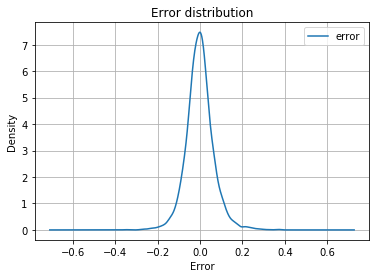

,error
count,338000.000000
mean,-0.101751
std,6.474328
min,-35.009874
25%,-3.844674
50%,-0.296426
75%,3.290145
max,36.832903


In [9]:
df_errors = pd.DataFrame({'error': [e for ls in errorGBR.tolist() for e in ls]})
df_errors.plot.kde()
plt.title("Error distribution")
plt.xlabel("Error")
plt.grid()
plt.show()

100 * df_errors.describe()

In [10]:
test_results = pd.DataFrame(
    {
        "y": y_train.values,
        "y_estimate": pd.to_numeric(estimatesGBR)
    }
)

100 * test_results.describe()

,y,y_estimate
count,338000.000000,338000.000000
mean,2.025067,2.126817
std,9.539470,5.202204
min,-38.831757,-21.264011
25%,-3.078896,-0.356628
50%,1.352222,1.557259
75%,6.295351,3.839639
max,72.686528,50.561720


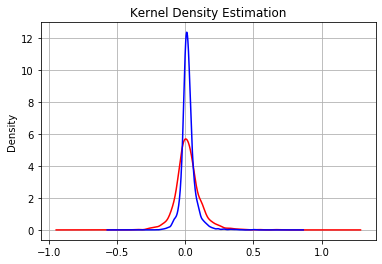

In [11]:
test_results.y.plot.kde(c='r')
test_results.y_estimate.plot.kde(c='b')
plt.title("Kernel Density Estimation")
plt.grid()
plt.show()

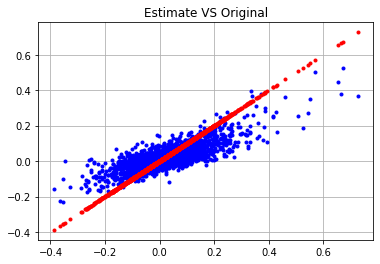

In [0]:
plt.plot(test_results.y, test_results.y_estimate, '.b')
plt.plot(test_results.y, test_results.y, '.r')
plt.title("Estimate VS Original")
plt.grid()
plt.show()